# Web Search and Text Mining -  Homework 1

## Question 1

In [5]:
######This marks the start of the Exercise
#We will create a Bag of Words model on movie reviews data on Kaggle

############### Importing the necessary packages and data
import pandas as pd
import numpy as np
import re

#Reading the labeled training data first
train = pd.read_csv("labeledTrainData.tsv", header=0,
                    delimiter="\t", quoting=3) #Quoting = 3 tells the reader to ignore double quotes

#Looking at the dataset
print("Exploring the data set: \n")
print(train.head())
print("\nDataset shape:")
print(train.shape)
print("\nDataset columns:")#Shape does not have any arguments so shape() will throw an error
print(train.columns.values)


#First review
print("\nPrinting the first review:")
print(train["review"][0])

############## Data Cleaning and Pre-processing
#The reviews contain html tags - these need to be removed
from bs4 import BeautifulSoup as BSoup

#Applying Soup to the first review
example1 = BSoup(train["review"][0], "lxml")
print("\nThe type of the beautiful soup object:")
print(type(example1)) #checking kind of object created - Beautiful soup object, not a string
print("\n")

#The xml is removed
#Remving xml using Regex is not the best practice

# "!!!" or ":-(" could carry sentiment, and should be treated as words
#For simplicity in Bag of Words we remove these.
#We will also remove numbers but it makes sense to replace them with words or placeholders

####Removing stop words

from nltk.corpus import stopwords # Import the stop word list
#print (stopwords.words("english"))

#We are not doing lemmatizing and porter stemming - which allows to treat words with the same context in the same way

#Creating a function to do this on the complete dataset
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BSoup(raw_review, "lxml").get_text()
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    #
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space,
    # and return the result.
    return(" ".join( meaningful_words ))

#Cleaning the complete dataset

# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list
print("Cleaning the reviews")
for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of clean reviews
    if (i + 1) % 1000 == 0:
        print("Review %d of %d\n" % (i + 1, num_reviews))
    clean_train_reviews.append( review_to_words( train["review"][i] ) )

#Create Bag of Words model

print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000) #This function could have done all pre processing by itself

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

#^^^^When we call the fit_transform method on the vectorizer, it acquires the feature names from the data.

print(type(train_data_features)) #This is a scipy sparse CSR matrix. CSR saves a lot of space compared to an sparse matrix


######################## Question 1

#Converting the CSR matrix to an array for computations
#Storage wise the CSR is better and compact but for computations, numpy arrays are easier to work with
X_counts = train_data_features.toarray()

#Verifying that there are counts more than 1
print("\nChecking that there are counts that are greater than 1:")
print(np.sum(X_counts[0:100, 0:100] > 1, axis = 1))
print("\nNumber of non zero entries:")
print(np.sum(np.sum(X_counts[0:100, 0:100] > 0, axis = 1) > 0))

X_binary = X_counts
X_binary[X_binary > 0] = 1

#Checking if there are counts more than 1 now
print("\nChecking that there are no counts > 1")
print(np.sum(X_binary[0:100, 0:100] > 1, axis = 1))
print("\nNumber of non zero entries:")
print(np.sum(np.sum(X_binary[0:100, 0:100] > 0, axis = 1) > 0))

print("Conversion from X_counts to X_binary is successful.")

#Creating the matrix X_tfidf
#tf-idf will weigh the words occurring frequently in all documents low.
#A potential problem with tf-idf is that some words that might be important and occurring in all docs (Trump in politics)
#will be weighted less. But in such a case, maybe that word is not that important.


from sklearn.feature_extraction.text import TfidfTransformer
#Using the defaults for the transformer - the smooth_idf = True ensures there is no division by 0. l2 norm.
#But here we use it = False
transformer = TfidfTransformer(smooth_idf=False)

X_tfidf = transformer.fit_transform(X_counts)

#Modifying in place to a numpy array
X_tfidf = X_tfidf.toarray()

print("\nPrinting shape of the tfidf array:")
print(X_tfidf.shape)


#Creating X_binary_imbalance
#This will contain less number of rows with sentiment = 1

X_binary_imbalance = X_counts
#To perform function, we take the sentiment column out, subset the sentiment = 1 rows, sample 0.75 of those and get
#their index values. Then we delete those index numbered rows from the main numpy array
X_binary_imbalance = np.delete(X_binary_imbalance,
                                  train["sentiment"][train["sentiment"]== 1].sample(frac = 0.75, random_state=0).index.values,
                                  axis = 0)

print("\nPrinting the shape of the binary_imbalance array:")
print(X_binary_imbalance.shape)

Exploring the data set: 

         id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

Dataset shape:
(25000, 3)

Dataset columns:
['id' 'sentiment' 'review']

Printing the first review:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at

## Question 2

In [10]:
########################## Question 2

#Writing the Euclidean distance function

def dist(X, i, j, distance_function = "Euclidean"):
    #Computing element wise subtraction array and then calculating its 2-norm for euclidean distance
    if distance_function == "Euclidean":
        return np.linalg.norm(X[i] - X[j])

#dist(X_counts, 2, 4,   distance_function="Euclidean")

from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter

#Writing the function to get k closest pairs
def topk(X, k):
    # Using the euclidean distances function to find the pairwise distance
    X_pairwise = euclidean_distances(X)
    #We will convert the symmetric matirx to an upper triangular for efficiency
    #Get the indices of the upper triangular 
    indices = np.triu_indices(X_pairwise.shape[0] , k = 1)
    X_pairwise = X_pairwise[indices]
    
    #Flattening the matrix
    ind = np.argpartition(X_pairwise, kth = k)
    X_pairwise = X_pairwise[ind[:k]]
    
    #Getting the indices
    i = indices[0][ind[:k]]
    j = indices[1][ind[:k]]
    top_pairs = []
    top_pairs = list(zip(i,j,X_pairwise))
    
    #Deleting the large matrices for efficiency
    del indices
    del ind
    
    #Sorting by the distances - lowest at the start
    #This return a list of tuples - indices of the
    #the reviews and the distance between the tuple pairs.
    return sorted(top_pairs , key = itemgetter(2)) 

In [68]:
#Defining function for making the tables

def make_df(matrix_top_list):
    top = pd.DataFrame(data = {"First_review_index": [i[0] for i in matrix_top_list],
                        "Second_review_index": [i[1] for i in matrix_top_list],
                       "Distance between the reviews": [i[2] for i in matrix_top_list],
                       "First 20 characters of the first review": 
                       [i[0:20] for i in train["review"][[i[0] for i in matrix_top_list]].values],
                       "First 20 characters of the second review":
                       [i[0:20] for i in train["review"][[i[1] for i in matrix_top_list]].values],
                       "Label for first review":
                       train["sentiment"][[i[0] for i in matrix_top_list]].values,
                       "Label for second review":
                       train["sentiment"][[i[1] for i in matrix_top_list]].values})
    
    cols = ["First_review_index", "Second_review_index", "Distance between the reviews",
                       "First 20 characters of the first review" ,
                       "First 20 characters of the second review",
                       "Label for first review",
                       "Label for second review"]
    
    
    return top[cols]

print("Printing the topk datasets in the following order: \n","1. Top 20 for X_counts \n",
"2. Top 20 for X_binary \n",
"3. Top 20 for X_tfidf \n",
"4. Top 20 for X_binary_imbalance")

Printing the topk datasets in the following order: 
 1. Top 20 for X_counts 
 2. Top 20 for X_binary 
 3. Top 20 for X_tfidf 
 4. Top 20 for X_binary_imbalance


In [53]:
print(make_df(topk(X_counts, 20)))

    First_review_index  Second_review_index  Distance between the reviews  \
0                 8087                10416                           0.0   
1                10506                14949                           0.0   
2                 6903                 7610                           0.0   
3                 2130                16784                           0.0   
4                 7248                 7915                           0.0   
5                 3256                17045                           0.0   
6                14104                22961                           0.0   
7                 9776                22278                           0.0   
8                 5519                14734                           0.0   
9                15381                23160                           0.0   
10                4723                 9740                           0.0   
11                2018                 6396                           0.0   

In [54]:
print(make_df(topk(X_binary, 20)))

    First_review_index  Second_review_index  Distance between the reviews  \
0                 8087                10416                           0.0   
1                10506                14949                           0.0   
2                 6903                 7610                           0.0   
3                 2130                16784                           0.0   
4                 7248                 7915                           0.0   
5                 3256                17045                           0.0   
6                14104                22961                           0.0   
7                 9776                22278                           0.0   
8                 5519                14734                           0.0   
9                15381                23160                           0.0   
10                4723                 9740                           0.0   
11                2018                 6396                           0.0   

In [64]:
print(make_df(topk(X_tfidf, 20)))

    First_review_index  Second_review_index  Distance between the reviews  \
0                 8087                10416                           0.0   
1                 1290                 1355                           0.0   
2                 1482                15194                           0.0   
3                 2465                16917                           0.0   
4                 3924                 5796                           0.0   
5                12399                17018                           0.0   
6                10709                14504                           0.0   
7                14935                24983                           0.0   
8                 4281                16250                           0.0   
9                 5745                23488                           0.0   
10                3264                 9390                           0.0   
11               11005                20550                           0.0   

In [65]:
print(make_df(topk(X_binary_imbalance, 20)))

    First_review_index  Second_review_index  Distance between the reviews  \
0                 8820                14363                           0.0   
1                11995                13324                           0.0   
2                 5799                12397                           0.0   
3                 2466                 3599                           0.0   
4                11100                11297                           0.0   
5                 1566                10609                           0.0   
6                 5436                14036                           0.0   
7                 6127                13801                           0.0   
8                 8785                15316                           0.0   
9                 9658                14492                           0.0   
10                6091                13936                           0.0   
11                2054                 5849                           0.0   

## Question 3

In [57]:
##########################Question 3

#Converting the matrices to CSR for faster computation
from scipy import sparse
X_counts = sparse.csr_matrix(X_counts)
X_binary = sparse.csr_matrix(X_binary)
X_tfidf = sparse.csr_matrix(X_tfidf)
X_binary_imbalance = sparse.csr_matrix(X_binary_imbalance)

#Creating a learning and set set split of 80-20 with random seed = 0

#First we need the predictor variable
dependent = np.array(train["sentiment"])

from sklearn.cross_validation import train_test_split

X_counts_train, X_counts_test, y_train, y_test = train_test_split(X_counts, dependent, test_size=0.2, random_state=0)

print("Printing shape of the divided datasets")
print(X_counts_train.shape, X_counts_test.shape, y_train.shape, y_test.shape)

#Fitting the linear SVM model
from sklearn import svm

#Fitting a regular SVM without CV to see baseline accurary
svm_prelim = svm.LinearSVC().fit(X_counts_train, y_train)
svm_prelim.score(X_counts_test, y_test)
print("\nThe accuracy without CV for Counts matrix is 0.824.")

#Computing the CV scores for random uniform values of C between 10-4 and 10+4
#We will record the ROC-AUC scores for each C value and compare

from sklearn.cross_validation import cross_val_score

score_list_counts = list()
c_list = np.logspace(-4, 4, num=30, endpoint=True, base = 10)

for i in c_list:
    svm_model_cv_counts = svm.LinearSVC(C = i, random_state = 0)
    #By default, the Linear SVC returns the mean accuracy
    #To use the ROC_AUC evaluator, we need: probability estimates of the positive class,
    # confidence values, or non-thresholded measure of decisions
    cv_score_counts = cross_val_score(svm_model_cv_counts, X_counts_train, y_train, cv = 5, scoring = "roc_auc")
    #assert isinstance(cv_score, object)
    score_list_counts.append(cv_score_counts)

#Getting the average AUC for each fold and the c-value needed
score_counts_avg = np.mean(score_list_counts, axis = 1)
c_value_counts = c_list[np.argmax(score_counts_avg)]
print("\n The best C value for counts matrix is", c_value_counts)


####### Doing the same process for the other matrices
#Making the datasets

X_binary_train, X_binary_test = train_test_split(X_binary, test_size=0.2, random_state=0)
X_tfidf_train, X_tfidf_test = train_test_split(X_tfidf, test_size=0.2, random_state=0)

###################For the imbalance, the dependent is different
dependent_imbalance = np.delete(np.array(train["sentiment"]),
                                  train["sentiment"][train["sentiment"]== 1].sample(frac = 0.75, random_state=0).index.values,
                                  axis = 0)

X_binary_imbalance_train, X_binary_imbalance_test, y_train_imbalance, y_test_imbalance  = \
    train_test_split(X_binary_imbalance, dependent_imbalance,
                     test_size=0.2, random_state=0)

#Getting C values for all matrices

#Binary Matrix
score_list_binary = list()

for i in c_list:
    svm_model_cv_binary = svm.LinearSVC(C = i, random_state = 0)
    cv_score_binary = cross_val_score(svm_model_cv_binary, X_binary_train,
                                      y_train, cv = 5, scoring = "roc_auc")
    score_list_binary.append(cv_score_binary)

#Getting the average AUC for each fold and the c-value needed
score_binary_avg = np.mean(score_list_binary, axis = 1)
c_value_binary = c_list[np.argmax(score_binary_avg)]
print("\n The best C value for binary matrix is" , c_value_binary)

#tfidf Matrix
score_list_tfidf = list()

for i in c_list:
    svm_model_cv_tfidf = svm.LinearSVC(C = i, random_state = 0)
    cv_score_tfidf = cross_val_score(svm_model_cv_tfidf, X_tfidf_train,
                                      y_train, cv = 5, scoring = "roc_auc")
    score_list_tfidf.append(cv_score_tfidf)

#Getting the average AUC for each fold and the c-value needed
score_tfidf_avg = np.mean(score_list_tfidf, axis = 1)
c_value_tfidf = c_list[np.argmax(score_tfidf_avg)]
print("\n The best C value for tfidf matrix is" , c_value_tfidf)

#Binary Imbalance matrix
score_list_binary_imbalance = list()

for i in c_list:
    svm_model_cv_binaryimb = svm.LinearSVC(C = i, random_state = 0)
    cv_score_binaryimb = cross_val_score(svm_model_cv_binaryimb, X_binary_imbalance_train,
                                      y_train_imbalance, cv = 5, scoring = "roc_auc")
    score_list_binary_imbalance.append(cv_score_tfidf)

#Getting the average AUC for each fold and the c-value needed
score_binaryimb_avg = np.mean(score_list_binary_imbalance, axis = 1)
c_value_binaryimb = c_list[np.argmax(score_binaryimb_avg)]
print("\n The best C value for binary imbalance matrix is" , c_value_binaryimb)


Printing shape of the divided datasets
(20000, 5000) (5000, 5000) (20000,) (5000,)

The accuracy without CV for Counts matrix is 0.824.

 The best C value for counts matrix is 0.00452035365636

 The best C value for binary matrix is 0.00452035365636

 The best C value for tfidf matrix is 0.108263673387

 The best C value for binary imbalance matrix is 0.0001


### Retraining the classifiers and making the plots

The accuracy with CV for Counts is 0.876

The AUC value for counts matrix is:
0.947316578784


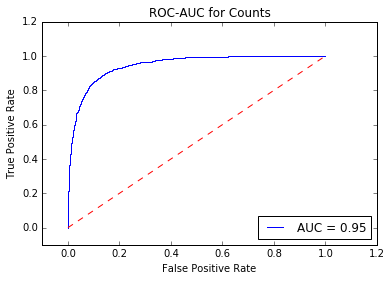

The accuracy with CV for Binary is 0.876

The AUC value for binary matrix is:
0.947316738843


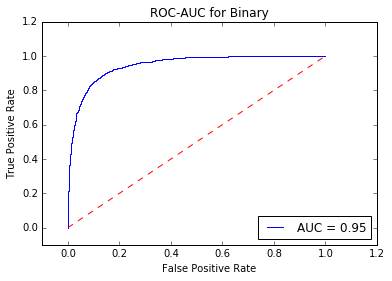

The accuracy with CV for tfidf is 0.8852

The AUC value for tfidf matrix is:
0.949724506442


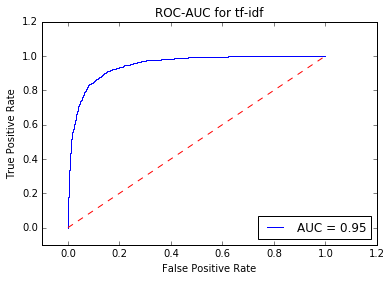

The accuracy with CV for binary imbalance is 0.80224

The AUC value for binary imbalance matrix is:
0.862775073957


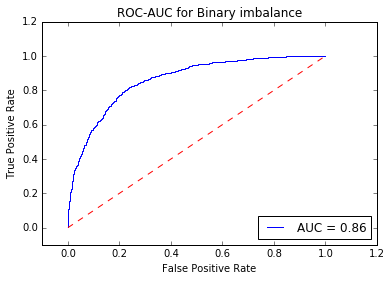

In [58]:
#Retraining the classifiers

#1. Counts
svm_counts = svm.LinearSVC(C = c_value_counts).fit(X_counts_train, y_train)
print("The accuracy with CV for Counts is {}".format(svm_counts.score(X_counts_test, y_test)))

#Plotting the ROC curve for Counts matrix
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline  

y_pred_counts = svm_counts.decision_function(X_counts_test)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, y_pred_counts)
auc1 = metrics.auc(fpr1,tpr1)
print("\nThe AUC value for counts matrix is:")
print(auc1)
plt.plot(fpr1, tpr1, 'b', label='AUC = %0.2f'% auc1)
plt.title('ROC-AUC for Counts')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#2. Binary
svm_binary = svm.LinearSVC(C = c_value_binary).fit(X_binary_train, y_train)
print("The accuracy with CV for Binary is {}".format(svm_binary.score(X_binary_test, y_test)))

#Plotting the ROC curve for Binary matrix
y_pred_binary = svm_binary.decision_function(X_binary_test)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test, y_pred_binary)
auc2 = metrics.auc(fpr2,tpr2)
print("\nThe AUC value for binary matrix is:")
print(auc2)
plt.plot(fpr2, tpr2, 'b', label='AUC = %0.2f'% auc2)
plt.title('ROC-AUC for Binary')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#3. tf-idf
svm_tfidf = svm.LinearSVC(C = c_value_tfidf).fit(X_tfidf_train, y_train)
print("The accuracy with CV for tfidf is {}".format(svm_tfidf.score(X_tfidf_test, y_test)))

#Plotting the ROC curve for Counts matrix
y_pred_tfidf = svm_counts.decision_function(X_tfidf_test)
fpr3, tpr3, threshold3 = metrics.roc_curve(y_test, y_pred_tfidf)
auc3 = metrics.auc(fpr3,tpr3)
print("\nThe AUC value for tfidf matrix is:")
print(auc3)
plt.plot(fpr3, tpr3, 'b', label='AUC = %0.2f'% auc3)
plt.title('ROC-AUC for tf-idf')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#4. Binary Imbalance
svm_binaryimb = svm.LinearSVC(C = c_value_binaryimb).fit(X_binary_imbalance_train, y_train_imbalance)
print("The accuracy with CV for binary imbalance is {}".format(svm_binaryimb.score(X_binary_imbalance_test, y_test_imbalance)))

#Plotting the ROC curve for Counts matrix
y_pred_binaryimb = svm_binaryimb.decision_function(X_binary_imbalance_test)
fpr4, tpr4, threshold4 = metrics.roc_curve(y_test_imbalance, y_pred_binaryimb)
auc4 = metrics.auc(fpr4,tpr4)
print("\nThe AUC value for binary imbalance matrix is:")
print(auc4)
plt.plot(fpr4, tpr4, 'b', label='AUC = %0.2f'% auc4)
plt.title('ROC-AUC for Binary imbalance')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Kaggle Submissions

In [59]:
#Reading in the test data for submission to Kaggle
test = pd.read_csv("testData.tsv", header=0,
                    delimiter="\t", quoting=3)

#Data Prep
clean_test_reviews = []

for i in range( 0,  len(test)):
    # Call our function for each one, and add the result to the list of clean reviews
    #if (i + 1) % 1000 == 0:
    #    print("Review %d of %d\n" % (i + 1, len(test)))
    clean_test_reviews.append( review_to_words( test["review"][i] ) )

#Using the train Vectorizer to transform the test data to a document term matrix
test_data_features = vectorizer.transform(clean_test_reviews)

#Training the models again on the complete data
#1. Counts
final_counts = svm.LinearSVC(C = c_value_counts).fit(X_counts, dependent)
counts_pred = final_counts.predict(test_data_features)
counts_out = test.copy()
counts_out["sentiment"] = counts_pred
del counts_out["review"]

#Have to remove quoting around the index
import csv
counts_out.to_csv("counts.csv", index = False, quoting = csv.QUOTE_NONE)

#2. Binary

#Making the test set for Binary
test_binary = test_data_features
test_binary[test_binary > 0] = 1

final_binary = svm.LinearSVC(C = c_value_binary).fit(X_binary, dependent)
binary_pred = final_binary.predict(test_binary)
binary_out = test.copy()
binary_out["sentiment"] = binary_pred
del binary_out["review"]

#Have to remove quoting around the index
binary_out.to_csv("binary.csv", index = False, quoting = csv.QUOTE_NONE)

#3. tfidf

#Making the test set for tfidf
test_tfidf = transformer.transform(test_data_features)

final_tfidf = svm.LinearSVC(C = c_value_tfidf).fit(X_tfidf, dependent)
tfidf_pred = final_tfidf.predict(test_tfidf)
tfidf_out = test.copy()
tfidf_out["sentiment"] = tfidf_pred
del tfidf_out["review"]

#Have to remove quoting around the index
tfidf_out.to_csv("tfidf.csv", index = False, quoting = csv.QUOTE_NONE)

#4. Binary imbalance

#Making the test set for Binary Imbalance

final_binaryimb = svm.LinearSVC(C = c_value_binaryimb).fit(X_binary_imbalance, dependent_imbalance)
binaryimb_pred = final_binaryimb.predict(test_data_features)
binaryimb_out = test.copy()
binaryimb_out["sentiment"] = binaryimb_pred
del binaryimb_out["review"]

#Have to remove quoting around the index
binaryimb_out.to_csv("binaryimb.csv", index = False, quoting = csv.QUOTE_NONE)

#### The final best accuracy obtained on Kaggle was 0.88352. The highest accuracy was obtained for X_tfidf. The accuracy of X_binary is also really close at 0.87820. As we saw the ROC-AUC values for the counts and tfidf matrices are very close (0.949724506442 for tfidf and 0.947316578784 for counts) so there was nothing stark to differentiate between them. Thus, on the test set, it cannot be predicted that which one would perform better. Tf-idf was expected to perform a little better as it also employs weighting the words according to their frequencies but it is not the case always.
#### The Lift between the best and worst AUC values is: 0.086949432485.
#### The worst is binary imbalace with AUC = 0.862775073957 and the best is tfidf with AUC = 0.949724506442

## Question 4

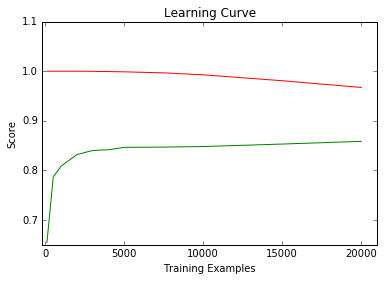

In [63]:
#################### Question4
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

#Getting the outputs for the learning curve
train_sizes, train_scores, validation = learning_curve(
    LogisticRegression(), X_counts, np.array(train["sentiment"]), 
    train_sizes=[100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000], 
    cv=5)

#Taking the mean of the scores
train_scores = np.mean(train_scores , axis = 1)
validation = np.mean(validation , axis = 1)

#Plotting the learning curve
plt.plot(train_sizes, train_scores, 'r', label='Training Score')
plt.plot(train_sizes, validation, 'g', label='Validation Score')
plt.title('Learning Curve')
plt.ylabel('Score')
plt.xlabel('Training Examples')
plt.ylim([0.65,1.1])
plt.xlim([-200,21000])
plt.show()


#### The learning curves do not converge. This tells us that we need more training samples for their convergence. Here too we are plotting 20000 but we have 25000 data points. As we add more training samples though, we will get poorer training scores as more the data, more complex is the  model and more is the error. However, at the same time, the testing score will increase as the model will learn the data better and make better out of sample predictions.